# Day 5: Model Evaluation & Validation

In this notebook, we will explore model evaluation techniques beyond simple accuracy.
We’ll cover:
- Confusion Matrix & Classification Report
- ROC Curve & AUC
- Precision-Recall Curve
- Threshold Tuning
- Stratified Cross-Validation

The goal: Understand why different metrics matter depending on the problem context (e.g., fraud detection, medical diagnosis).

In [1]:
# Install required libraries
!pip install scikit-learn matplotlib seaborn --quiet

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Load dataset (binary classification)
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## 1. Training Baseline Models
We’ll train a few different models for comparison.

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

models = {
    'Logistic Regression': make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, solver='lbfgs')),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f"{name} trained.")


Logistic Regression trained.
Decision Tree trained.
Random Forest trained.


## 2. Confusion Matrix & Classification Report
These help us understand performance on each class, not just overall accuracy.


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



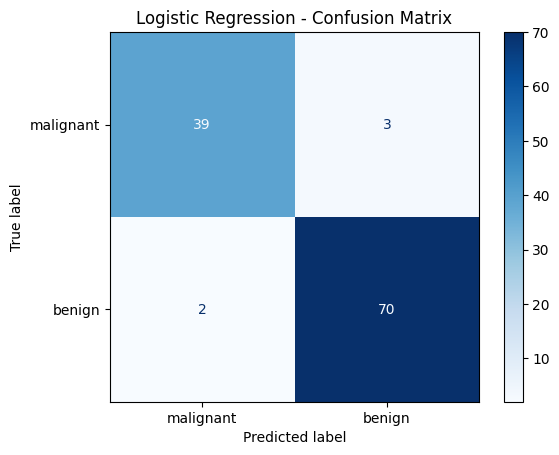


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89        42
           1       0.96      0.90      0.93        72

    accuracy                           0.91       114
   macro avg       0.90      0.92      0.91       114
weighted avg       0.92      0.91      0.91       114



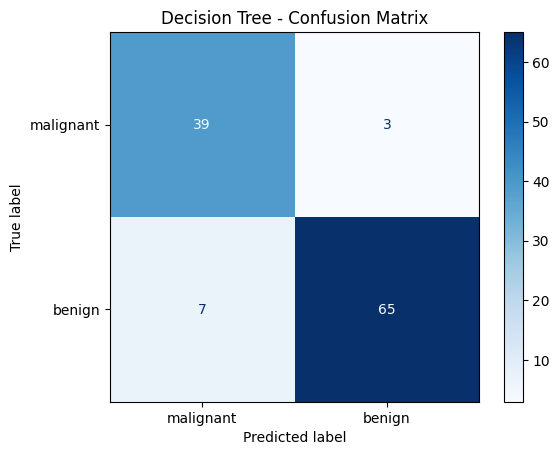


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



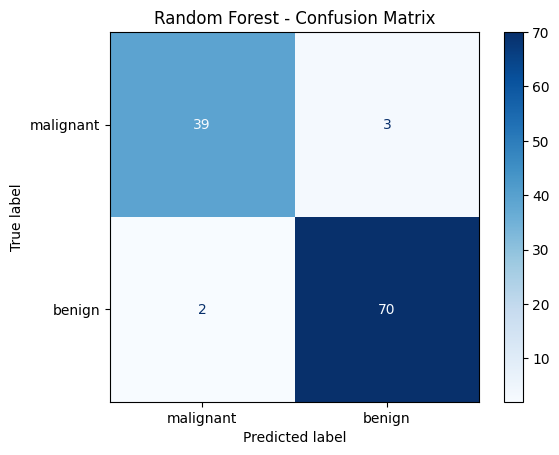

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay

for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=data.target_names)
    disp.plot(cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

## 3. ROC Curve & AUC
ROC curves show the trade-off between True Positive Rate and False Positive Rate. AUC summarizes it.

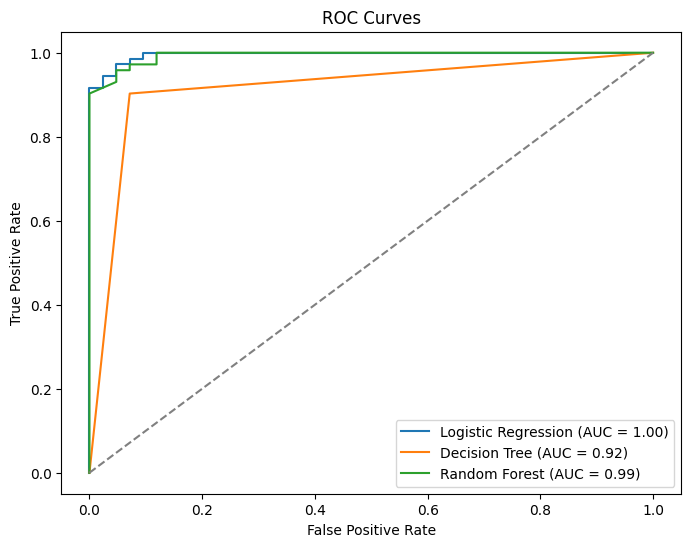

In [5]:
plt.figure(figsize=(8,6))

for name, model in trained_models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

## 4. Precision-Recall Curve
Useful for imbalanced datasets where ROC can be misleading.

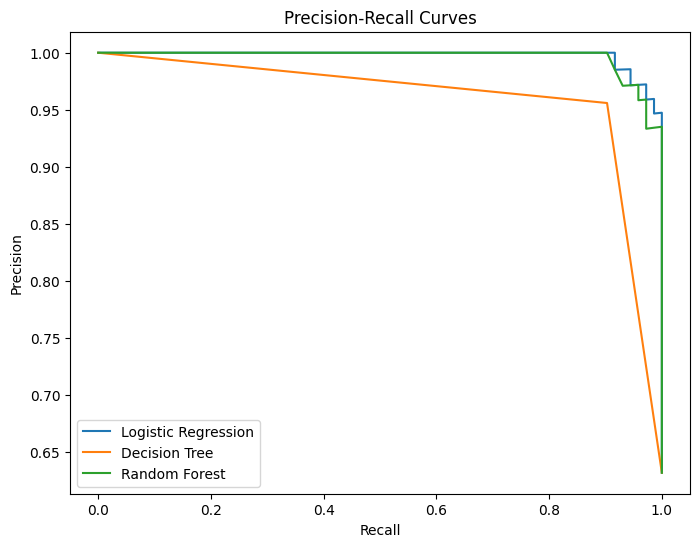

In [6]:
plt.figure(figsize=(8,6))

for name, model in trained_models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, label=name)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()

## 5. Threshold Tuning
We can adjust the classification threshold to favor precision or recall depending on the problem.

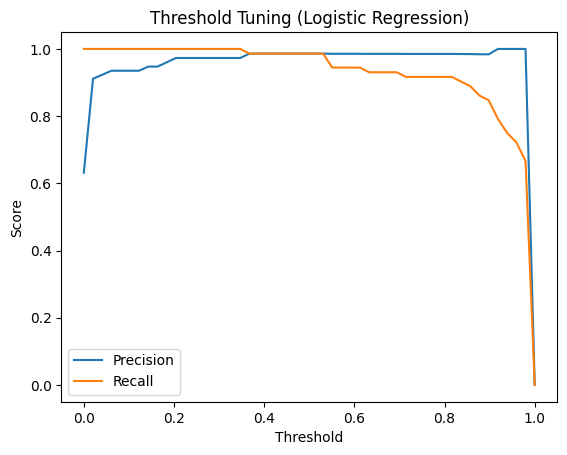

In [10]:
model = trained_models['Logistic Regression']
y_prob = model.predict_proba(X_test)[:,1]

thresholds = np.linspace(0, 1, 50)
precisions, recalls = [], []

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)  # 👈 added
    precisions.append(report['1']['precision'])
    recalls.append(report['1']['recall'])

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Tuning (Logistic Regression)')
plt.legend()
plt.show()


## 6. Stratified Cross-Validation
Stratified K-Fold ensures each fold has the same class distribution as the dataset.

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Rebuild models with scaling for Logistic Regression
models = {
    'Logistic Regression': make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000, solver='lbfgs')),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Stratified Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=skf, scoring='f1')
    print(f"{name}: Mean F1 = {scores.mean():.3f} (+/- {scores.std():.3f})")


Logistic Regression: Mean F1 = 0.979 (+/- 0.013)
Decision Tree: Mean F1 = 0.930 (+/- 0.020)
Random Forest: Mean F1 = 0.965 (+/- 0.010)


## 🔑 Key Takeaways
- Accuracy alone can be misleading, especially with imbalanced datasets.
- Precision, Recall, and F1-score help capture trade-offs.
- ROC & Precision-Recall curves provide visual insights.
- Threshold tuning customizes models to business needs.
- Cross-validation ensures more reliable evaluation.

